In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os  
import tensorflow as tf
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from glob import glob
import plotly.express as px
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras
from keras.utils.np_utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.utils import compute_sample_weight, compute_class_weight
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


C:\Users\bobby\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\bobby\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\bobby\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\bobby\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

In [2]:
# Making Dictionary of images and labels
skin_dir = os.path.join('.', 'input')
# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(skin_dir, '*', '*.jpg'))}
# Create dictionary human-friendly labels 
type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
# Check again input data
os.listdir('.\\input')

['HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv.zip',
 'hmnist_28_28_RGB.csv.zip',
 'hmnist_8_8_L.csv.zip',
 'hmnist_8_8_RGB.csv.zip']

In [4]:
skin_data = pd.read_csv(os.path.join(skin_dir, 'HAM10000_metadata.csv'))
skin_data.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [5]:
# Creating New Columns 
skin_data['path'] = skin_data['image_id'].map(imageid_path_dict.get)
skin_data['cell_type'] = skin_data['dx'].map(type_dict.get) 
skin_data['cell_id'] = pd.Categorical(skin_data['cell_type']).codes

In [6]:
# Now lets see the sample of data frame to look on newly made columns
skin_data.sample(5)

lesion_id      image_id     dx dx_type   age     sex     localization  \
1127  HAM_0004960  ISIC_0029967     df   histo  65.0  female  lower extremity   
7965  HAM_0005312  ISIC_0034231     nv   histo  20.0  female             back   
2089  HAM_0006004  ISIC_0027702    mel   histo  70.0  female             back   
9997  HAM_0006180  ISIC_0028990  akiec   histo  70.0    male  upper extremity   
2127  HAM_0002493  ISIC_0027436    mel   histo  50.0    male  lower extremity   

                                                 path          cell_type  \
1127  .\input\HAM10000_images_part_2\ISIC_0029967.jpg     Dermatofibroma   
7965  .\input\HAM10000_images_part_2\ISIC_0034231.jpg   Melanocytic nevi   
2089  .\input\HAM10000_images_part_1\ISIC_0027702.jpg           Melanoma   
9997  .\input\HAM10000_images_part_1\ISIC_0028990.jpg  Actinic keratoses   
2127  .\input\HAM10000_images_part_1\ISIC_0027436.jpg           Melanoma   

      cell_id  
1127        3  
7965        4  
2089        5  
9997        0  
2127        5

In [7]:
#Data Preprocessing
#Cleaning Data
skin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
lesion_id       10015 non-null object
image_id        10015 non-null object
dx              10015 non-null object
dx_type         10015 non-null object
age             9958 non-null float64
sex             10015 non-null object
localization    10015 non-null object
path            10015 non-null object
cell_type       10015 non-null object
cell_id         10015 non-null int8
dtypes: float64(1), int8(1), object(8)
memory usage: 714.0+ KB


In [8]:
skin_data.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
path             0
cell_type        0
cell_id          0
dtype: int64

In [9]:
skin_data = skin_data.dropna(how='any')
skin_data.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
path            0
cell_type       0
cell_id         0
dtype: int64

In [10]:
print(skin_data.dtypes)

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
path             object
cell_type        object
cell_id            int8
dtype: object


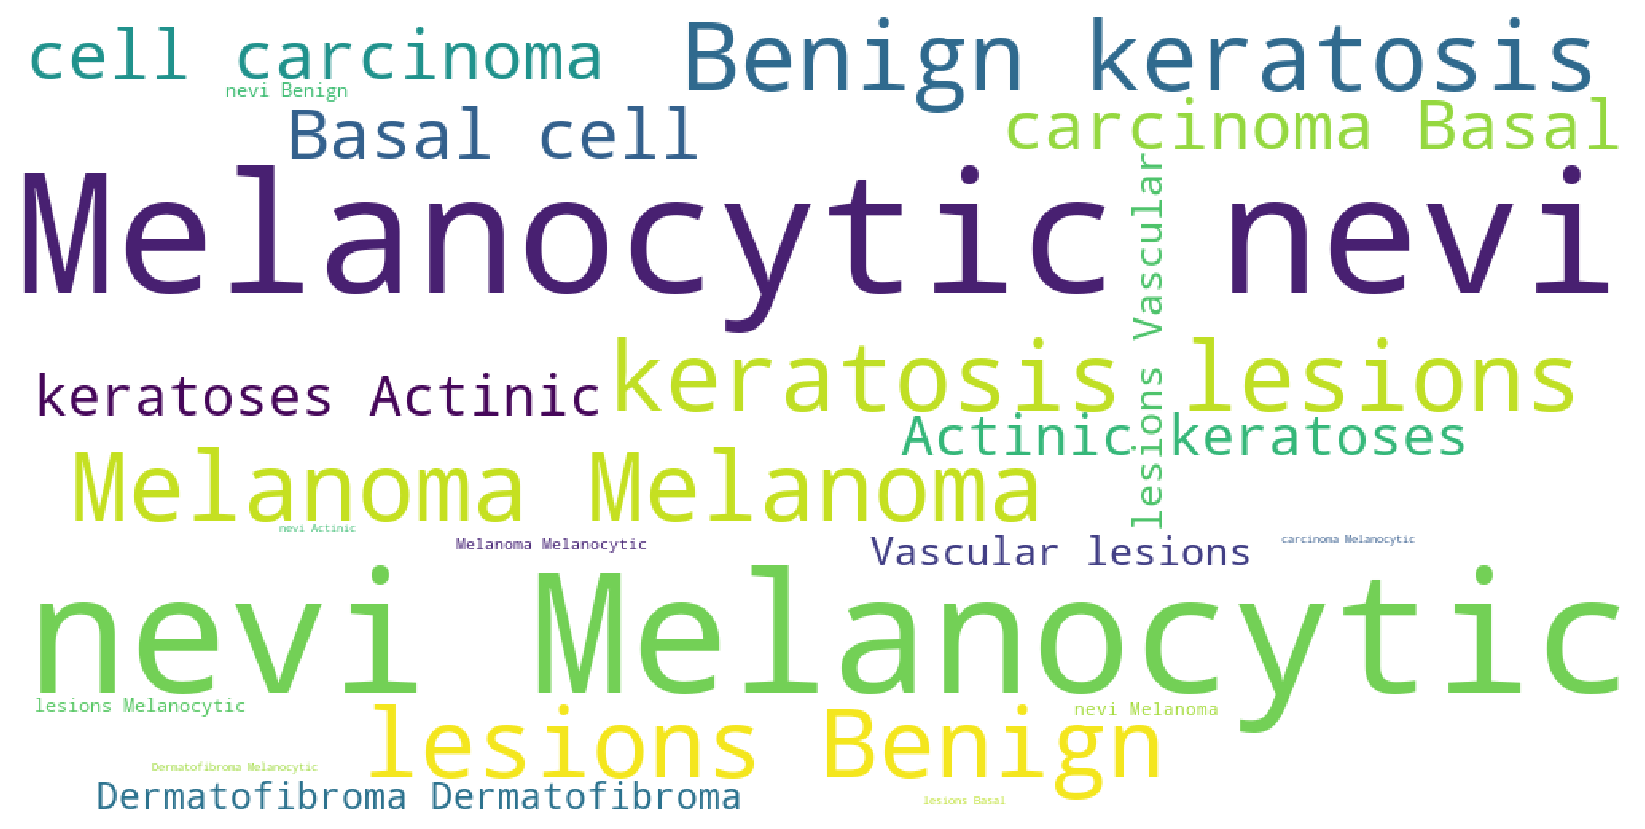

In [11]:
#Data Visualization
data = skin_data.cell_type
plt.subplots(figsize=(30,15))
wordcloud = WordCloud(
                          background_color='white',
                          width=1024,
                          height=512
                         ).generate(" ".join(data))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('graph_cell.png')

plt.show()

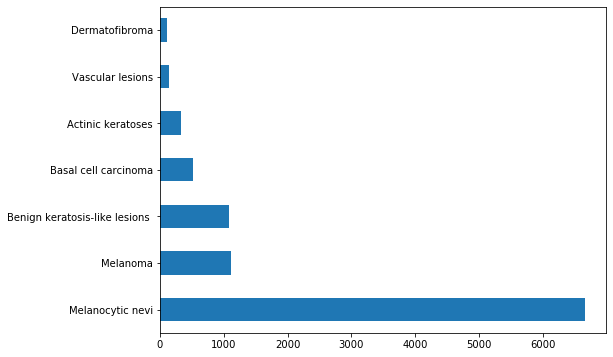

In [12]:
fig, ax1 = plt.subplots(1, 1, figsize= (8, 6))
skin_data['cell_type'].value_counts().plot(kind='barh', ax=ax1)

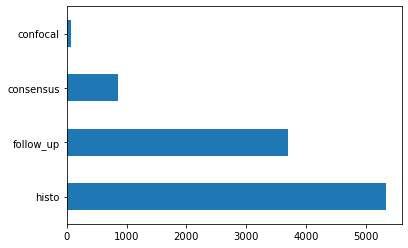

In [13]:
skin_data['dx_type'].value_counts().plot(kind='barh')

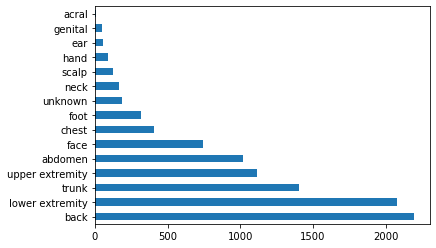

In [14]:
skin_data['localization'].value_counts().plot(kind='barh')

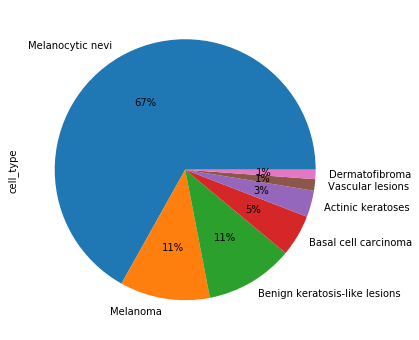

In [15]:
fig, ax1 = plt.subplots(1, 1, figsize= (6, 6))
skin_data['cell_type'].value_counts().plot(kind='pie', autopct='%1.0f%%', ax=ax1)

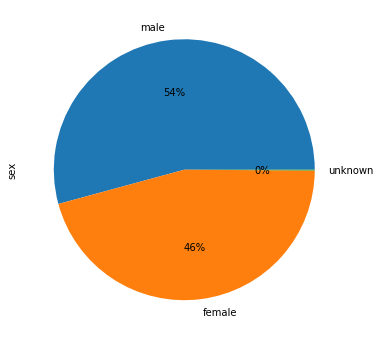

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize= (6, 6))
skin_data['sex'].value_counts().plot(kind='pie', autopct='%1.0f%%', ax=ax1)

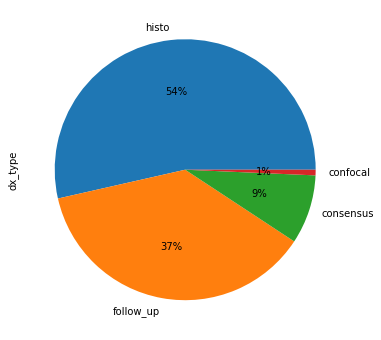

In [17]:
fig, ax1 = plt.subplots(1, 1, figsize= (6, 6))
skin_data['dx_type'].value_counts().plot(kind='pie', autopct='%1.0f%%', ax=ax1)

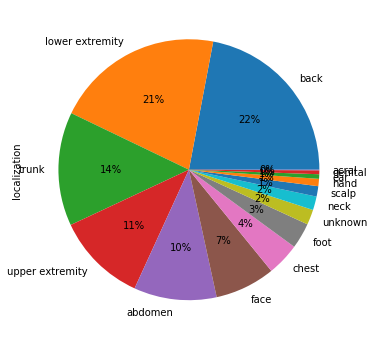

In [18]:
fig, ax1 = plt.subplots(1, 1, figsize= (6, 6))
skin_data['localization'].value_counts().plot(kind='pie', autopct='%1.0f%%', ax=ax1)

In [19]:
fig = px.scatter_3d(skin_data, x='localization', y='cell_type', z='sex', color='cell_type')
fig.show()

In [20]:
fig = px.scatter_3d(skin_data, x='localization', y='cell_type', z='age', color='cell_type')
fig.show()

In [21]:
#resize all the images
skin_data['image'] = skin_data['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))
skin_data.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                              path  \
0  .\input\HAM10000_images_part_1\ISIC_0027419.jpg   
1  .\input\HAM10000_images_part_1\ISIC_0025030.jpg   
2  .\input\HAM10000_images_part_1\ISIC_0026769.jpg   
3  .\input\HAM10000_images_part_1\ISIC_0025661.jpg   
4  .\input\HAM10000_images_part_2\ISIC_0031633.jpg   

                        cell_type  cell_id  \
0  Benign keratosis-like lesions         2   
1  Benign keratosis-like lesions         2   
2  Benign keratosis-like lesions         2   
3  Benign keratosis-like lesions         2   
4  Benign keratosis-like lesions         2   

                                               image  
0  [[[191, 153, 194], [191, 154, 198], [189, 152,...  
1  [[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3...  
2  [[[186, 126, 136], [190, 136, 149], [195, 137,...  
3  [[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6...  
4  [[[136, 91, 114], [148, 104, 127], [161, 117, ...

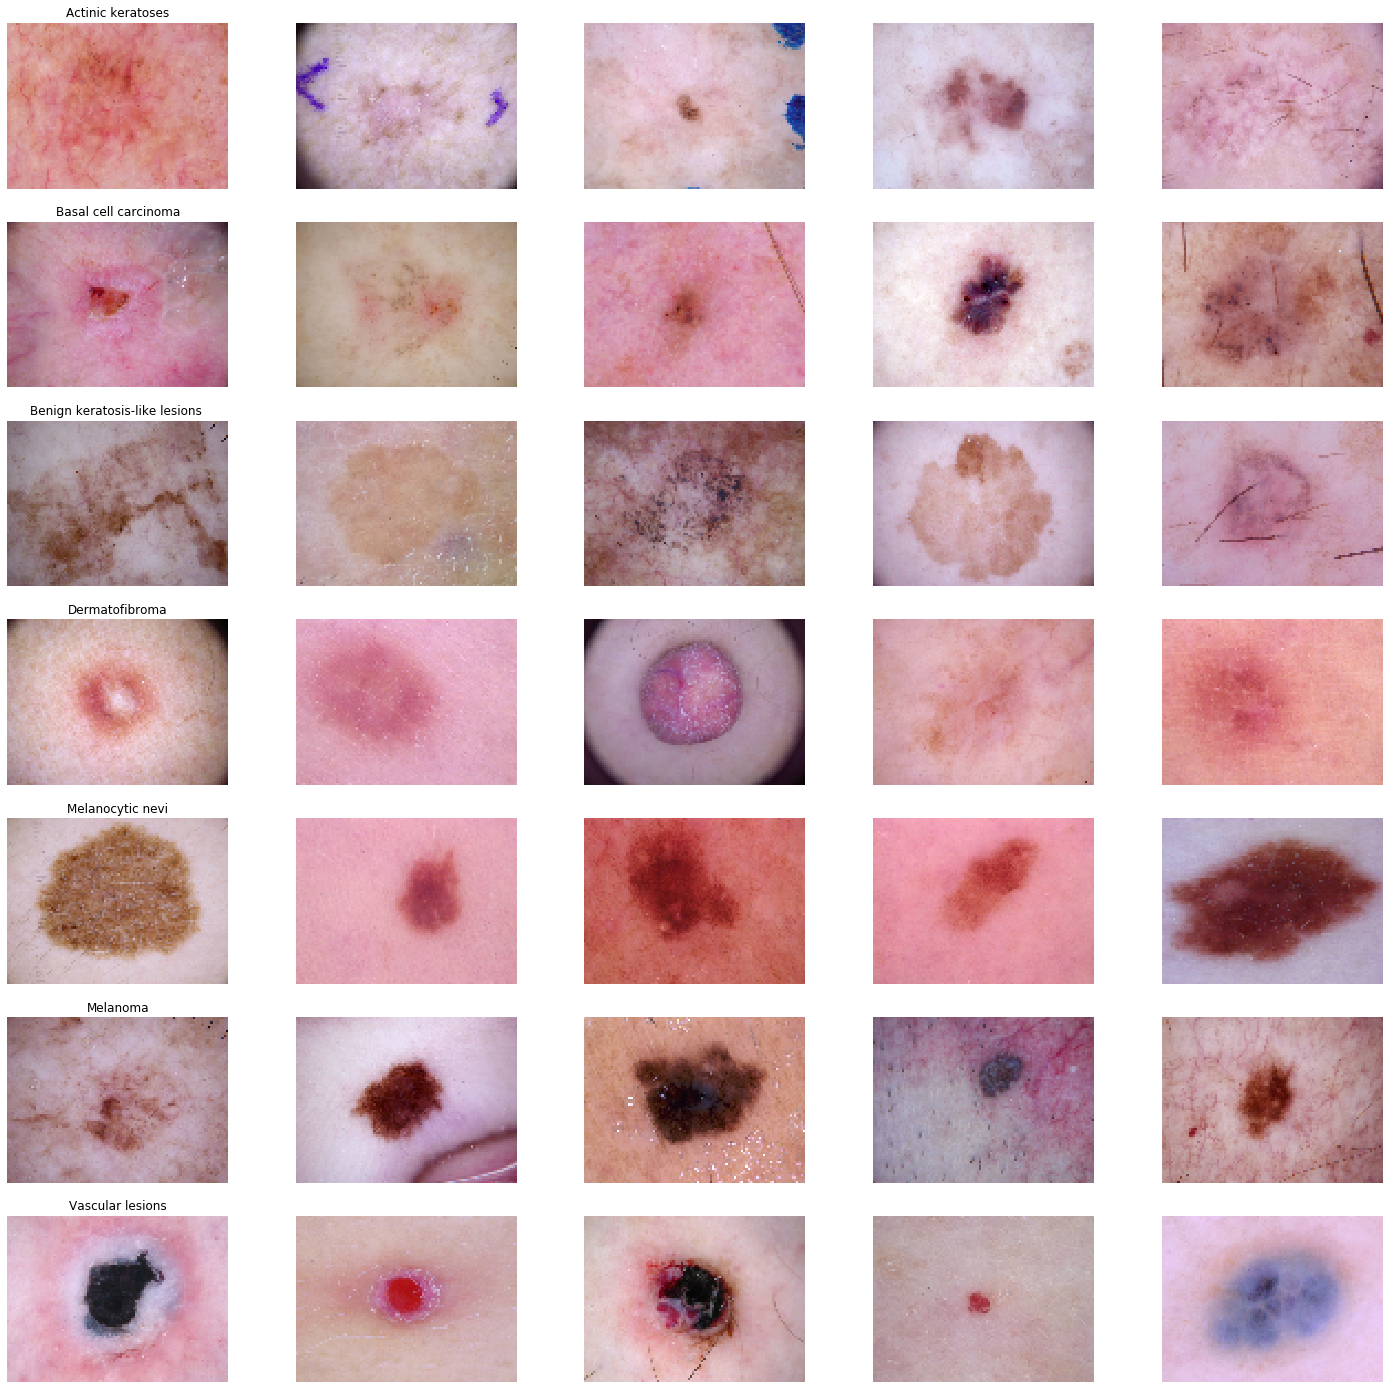

In [22]:
#printing some sample image
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (5*n_samples, 5*5))
for n_axs, (type_name, type_rows) in zip(m_axs, skin_data.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=24).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=100)

In [23]:
# Checking the image size distribution
skin_data['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    9958
Name: image, dtype: int64

In [24]:
#Convolutional Neural Network

#Train Test Split 
X_train=skin_data.drop(columns=['cell_id'],axis=1)
Y_train=skin_data['cell_id']
x_o_train, x_o_test, y_o_train, y_o_test = train_test_split(X_train, Y_train, test_size=0.10,random_state=24)
#Label Encoding
#Labels are 7 different classes of cell types from 0 to 6. We need to encode these lables to one hot vectors.
y_train = to_categorical(y_o_train, num_classes = 7)
y_test = to_categorical(y_o_test, num_classes = 7)
#Normalization
x_train = np.asarray(x_o_train['image'].tolist())
x_test = np.asarray(x_o_test['image'].tolist())
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
#Training and Validation Split
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [25]:
#Data Augmentation to avoiding the overfitting.
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [26]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [27]:
# tanh + Adagrad
classifier = Sequential()
input_shape = (75, 100, 3)

classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'tanh', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'tanh', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.25))

classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'tanh', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'tanh', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))

classifier.add(Conv2D(128, kernel_size= (3,3), activation= 'tanh', padding= 'Same'))
classifier.add(Conv2D(128, kernel_size= (3,3), activation= 'tanh', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))


classifier.add(Flatten())
classifier.add(Dense(128, activation= 'tanh'))
classifier.add(Dropout(0.5))


classifier.add(Dense(7, activation= 'softmax'))
classifier.summary()


classifier.compile(optimizer='Adagrad',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 25, 64)        0

In [28]:
epochs = 50
batch_size = 100
history = classifier.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/50
80/80 [==============================] - 19s 242ms/step - loss: 1.2855 - accuracy: 0.6310 - val_loss: 1.0477 - val_accuracy: 0.6276
Epoch 2/50
 1/80 [..............................] - ETA: 6s - loss: 0.8134 - accuracy: 0.7300

C:\Users\bobby\AppData\Roaming\Python\Python37\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning:

Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr



80/80 [==============================] - 15s 182ms/step - loss: 0.8906 - accuracy: 0.6840 - val_loss: 1.3777 - val_accuracy: 0.5106
Epoch 3/50
80/80 [==============================] - 16s 197ms/step - loss: 0.8448 - accuracy: 0.6964 - val_loss: 1.1116 - val_accuracy: 0.5942
Epoch 4/50
80/80 [==============================] - 15s 186ms/step - loss: 0.8321 - accuracy: 0.7031 - val_loss: 1.5891 - val_accuracy: 0.4292
Epoch 5/50
80/80 [==============================] - 16s 196ms/step - loss: 0.8173 - accuracy: 0.7058 - val_loss: 1.3184 - val_accuracy: 0.5206
Epoch 6/50
80/80 [==============================] - 16s 199ms/step - loss: 0.8091 - accuracy: 0.7037 - val_loss: 1.3712 - val_accuracy: 0.4771
Epoch 7/50
80/80 [==============================] - 14s 179ms/step - loss: 0.7974 - accuracy: 0.7150 - val_loss: 1.3770 - val_accuracy: 0.5095
Epoch 8/50
80/80 [==============================] - 14s 178ms/step - loss: 0.7847 - accuracy: 0.7134 - val_loss: 1.3633 - val_accuracy: 0.4872
Epoch 9/50

In [29]:
loss, accuracy = classifier.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = classifier.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

897/897 [==============================] - 1s 1ms/sample - loss: 1.2383 - accuracy: 0.5596
Validation: accuracy = 0.559643  ;  loss_v = 1.238326
Test: accuracy = 0.580321  ;  loss = 1.185168


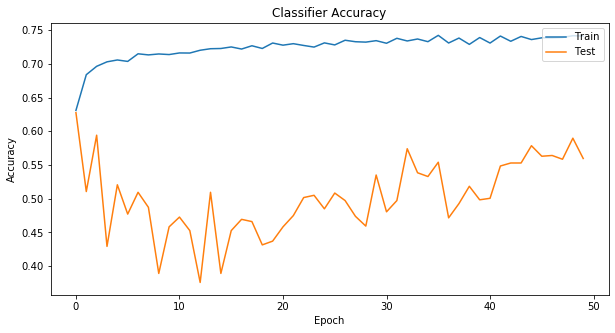

<Figure size 432x288 with 0 Axes>

In [30]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Classifier Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("tanh+adgard_acc.png")

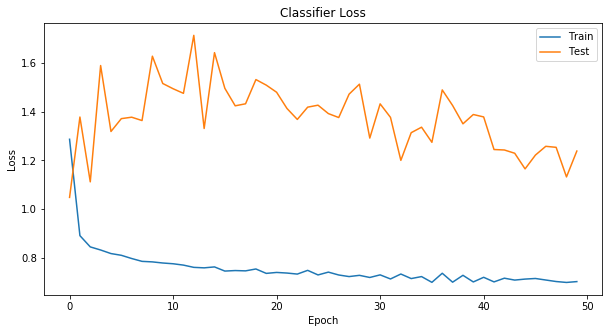

<Figure size 432x288 with 0 Axes>

In [31]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Classifier Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("tanh+adgard_loss.png")

In [32]:
# tanh + Adam
classifier = Sequential()
input_shape = (75, 100, 3)

classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'tanh', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'tanh', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.25))

classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'tanh', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'tanh', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))

classifier.add(Conv2D(128, kernel_size= (3,3), activation= 'tanh', padding= 'Same'))
classifier.add(Conv2D(128, kernel_size= (3,3), activation= 'tanh', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))


classifier.add(Flatten())
classifier.add(Dense(128, activation= 'tanh'))
classifier.add(Dropout(0.5))


classifier.add(Dense(7, activation= 'softmax'))
classifier.summary()


classifier.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 25, 64)       

In [33]:
epochs = 50
batch_size = 100
history = classifier.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/50
80/80 [==============================] - 35s 438ms/step - loss: 1.7253 - accuracy: 0.5895 - val_loss: 1.2073 - val_accuracy: 0.6656
Epoch 2/50
80/80 [==============================] - 33s 412ms/step - loss: 1.3314 - accuracy: 0.6044 - val_loss: 1.1462 - val_accuracy: 0.6644
Epoch 3/50
80/80 [==============================] - 28s 350ms/step - loss: 1.2587 - accuracy: 0.6323 - val_loss: 1.0822 - val_accuracy: 0.6633
Epoch 4/50
80/80 [==============================] - 28s 350ms/step - loss: 1.2163 - accuracy: 0.6354 - val_loss: 1.0882 - val_accuracy: 0.6644
Epoch 5/50
80/80 [==============================] - 27s 342ms/step - loss: 1.1929 - accuracy: 0.6390 - val_loss: 1.0850 - val_accuracy: 0.6644
Epoch 6/50
80/80 [==============================] - 27s 340ms/step - loss: 1.1609 - accuracy: 0.6516 - val_loss: 1.0820 - val_accuracy: 0.6644
Epoch 7/50
80/80 [==============================] - 27s 341ms/step - loss: 1.0950 - accuracy: 0.6600 - val_loss: 1.0476 - val_accuracy: 0.6678

In [34]:
loss, accuracy = classifier.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = classifier.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

897/897 [==============================] - 0s 472us/sample - loss: 0.9360 - accuracy: 0.6800
Validation: accuracy = 0.680045  ;  loss_v = 0.935965
Test: accuracy = 0.670683  ;  loss = 0.912595


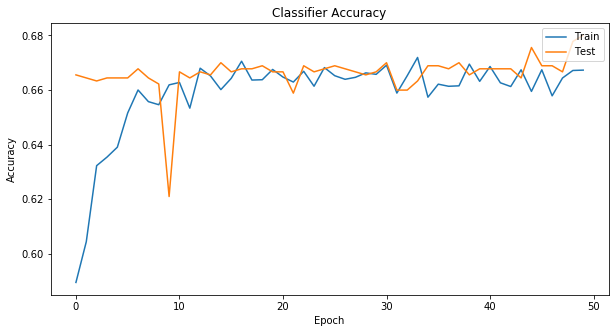

<Figure size 432x288 with 0 Axes>

In [35]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Classifier Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("tanh+adam_acc.png")


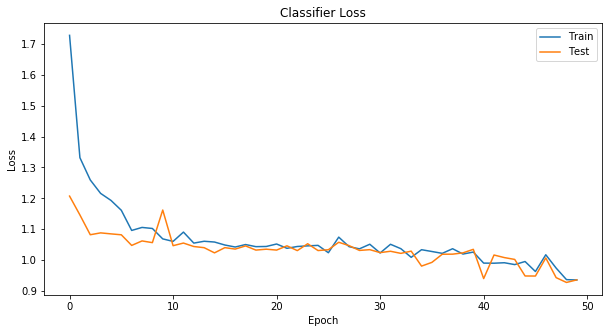

<Figure size 432x288 with 0 Axes>

In [36]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Classifier Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("tanh+adam_loss.png")


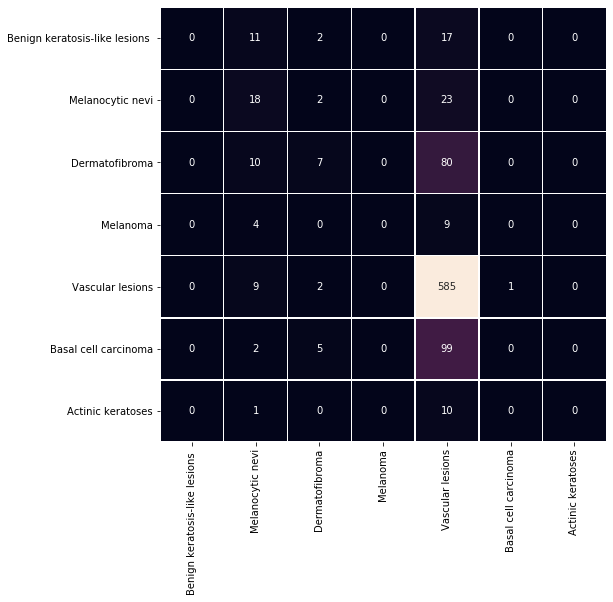

In [37]:
Y_pred = classifier.predict(x_validate)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_validate,axis = 1) 
cm = confusion_matrix(Y_true, Y_pred_classes)
label = pd.unique(skin_data['cell_type'])
f,ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(cm, xticklabels=label, yticklabels=label, linewidths=.5 , cbar=False , fmt="d" , annot=True)
plt.savefig("corr_tanh_adam.png")
plt.show()

In [38]:
# tanh + RMSprop
classifier = Sequential()
input_shape = (75, 100, 3)

classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'tanh', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'tanh', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.25))

classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'tanh', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'tanh', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))

classifier.add(Conv2D(128, kernel_size= (3,3), activation= 'tanh', padding= 'Same'))
classifier.add(Conv2D(128, kernel_size= (3,3), activation= 'tanh', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))


classifier.add(Flatten())
classifier.add(Dense(128, activation= 'tanh'))
classifier.add(Dropout(0.5))


classifier.add(Dense(7, activation= 'softmax'))
classifier.summary()


classifier.compile(optimizer='RMSprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 25, 64)       

In [39]:
epochs = 50
batch_size = 100
history = classifier.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/50
80/80 [==============================] - 21s 257ms/step - loss: 4.1889 - accuracy: 0.2379 - val_loss: 1.1679 - val_accuracy: 0.6656
Epoch 2/50
80/80 [==============================] - 22s 271ms/step - loss: 1.3952 - accuracy: 0.6116 - val_loss: 1.2037 - val_accuracy: 0.6488
Epoch 3/50
80/80 [==============================] - 21s 263ms/step - loss: 1.3256 - accuracy: 0.6333 - val_loss: 1.1946 - val_accuracy: 0.6656
Epoch 4/50
80/80 [==============================] - 22s 272ms/step - loss: 1.3034 - accuracy: 0.6516 - val_loss: 1.1532 - val_accuracy: 0.6656
Epoch 5/50
80/80 [==============================] - 19s 242ms/step - loss: 1.2358 - accuracy: 0.6650 - val_loss: 1.1595 - val_accuracy: 0.6656
Epoch 6/50
80/80 [==============================] - 18s 223ms/step - loss: 1.2186 - accuracy: 0.6665 - val_loss: 1.1573 - val_accuracy: 0.6656
Epoch 7/50
80/80 [==============================] - 18s 229ms/step - loss: 1.2027 - accuracy: 0.6688 - val_loss: 1.1439 - val_accuracy: 0.6667

In [40]:
loss, accuracy = classifier.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = classifier.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

897/897 [==============================] - 0s 528us/sample - loss: 1.1440 - accuracy: 0.6656
Validation: accuracy = 0.665552  ;  loss_v = 1.144034
Test: accuracy = 0.670683  ;  loss = 1.129917


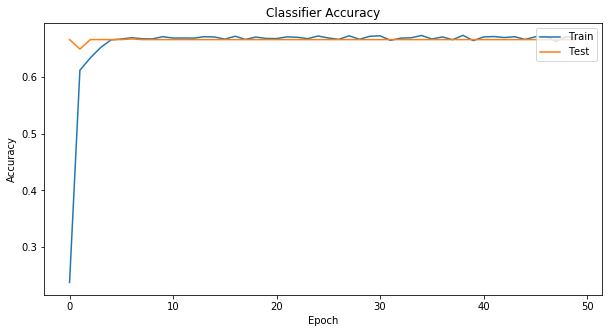

<Figure size 432x288 with 0 Axes>

In [41]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Classifier Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("tanh+RMsporp_acc.png")

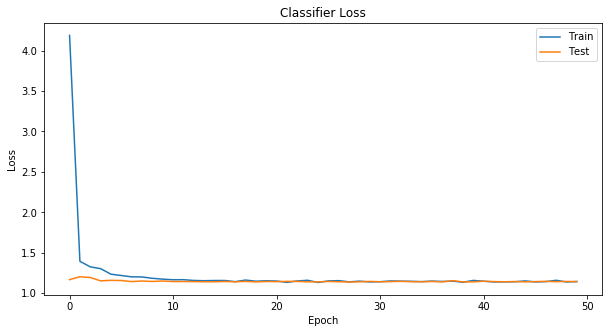

<Figure size 432x288 with 0 Axes>

In [42]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Classifier Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("tanh+RMsporp_loss.png")


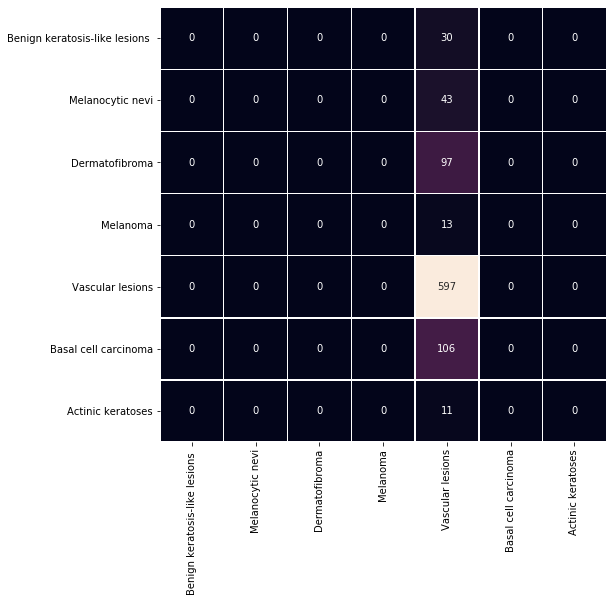

In [43]:
Y_pred = classifier.predict(x_validate)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_validate,axis = 1) 
cm = confusion_matrix(Y_true, Y_pred_classes)
label = pd.unique(skin_data['cell_type'])
f,ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(cm, xticklabels=label, yticklabels=label, linewidths=.5 , cbar=False , fmt="d" , annot=True)
plt.savefig("corr_tanh_rmsprop.png")
plt.show()

In [44]:
# relu+Adagrad
classifier = Sequential()
input_shape = (75, 100, 3)

classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.25))

classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'relu', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))

classifier.add(Conv2D(128, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
classifier.add(Conv2D(128, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))


classifier.add(Flatten())
classifier.add(Dense(128, activation= 'relu'))
classifier.add(Dropout(0.5))


classifier.add(Dense(7, activation= 'softmax'))
classifier.summary()


classifier.compile(optimizer='Adagrad',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 18, 25, 64)       

In [45]:
epochs = 50
batch_size = 100
history = classifier.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/50
80/80 [==============================] - 28s 354ms/step - loss: 1.0687 - accuracy: 0.6565 - val_loss: 1.0920 - val_accuracy: 0.6633
Epoch 2/50
80/80 [==============================] - 26s 320ms/step - loss: 0.9720 - accuracy: 0.6630 - val_loss: 1.0812 - val_accuracy: 0.6745
Epoch 3/50
80/80 [==============================] - 26s 320ms/step - loss: 0.9388 - accuracy: 0.6674 - val_loss: 1.0040 - val_accuracy: 0.6734
Epoch 4/50
80/80 [==============================] - 26s 322ms/step - loss: 0.9279 - accuracy: 0.6667 - val_loss: 0.9840 - val_accuracy: 0.6789
Epoch 5/50
80/80 [==============================] - 26s 325ms/step - loss: 0.9124 - accuracy: 0.6694 - val_loss: 0.9468 - val_accuracy: 0.6812
Epoch 6/50
80/80 [==============================] - 27s 335ms/step - loss: 0.8919 - accuracy: 0.6736 - val_loss: 0.9560 - val_accuracy: 0.6901
Epoch 7/50
80/80 [==============================] - 27s 334ms/step - loss: 0.8698 - accuracy: 0.6847 - val_loss: 0.9492 - val_accuracy: 0.6812

In [46]:
loss, accuracy = classifier.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = classifier.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

897/897 [==============================] - 0s 491us/sample - loss: 0.8578 - accuracy: 0.6667
Validation: accuracy = 0.666667  ;  loss_v = 0.857815
Test: accuracy = 0.696787  ;  loss = 0.851963


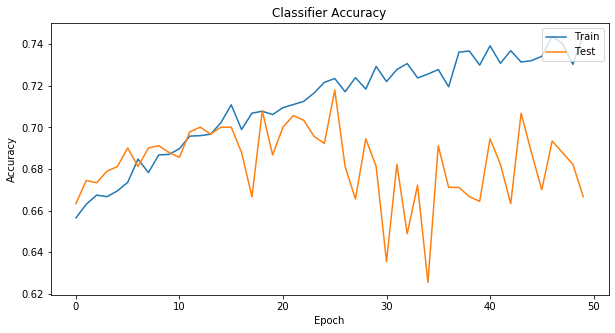

<Figure size 432x288 with 0 Axes>

In [47]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Classifier Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("relu+adagrad_acc.png")

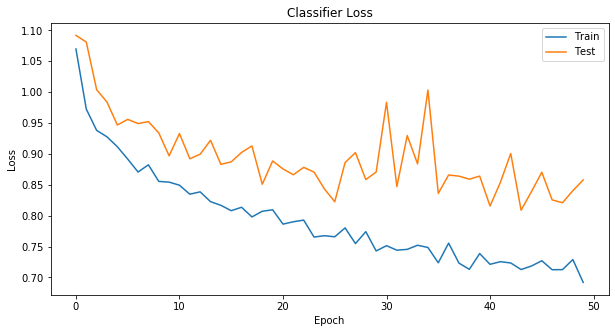

<Figure size 432x288 with 0 Axes>

In [48]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Classifier Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("relu+adagrad_loss.png")


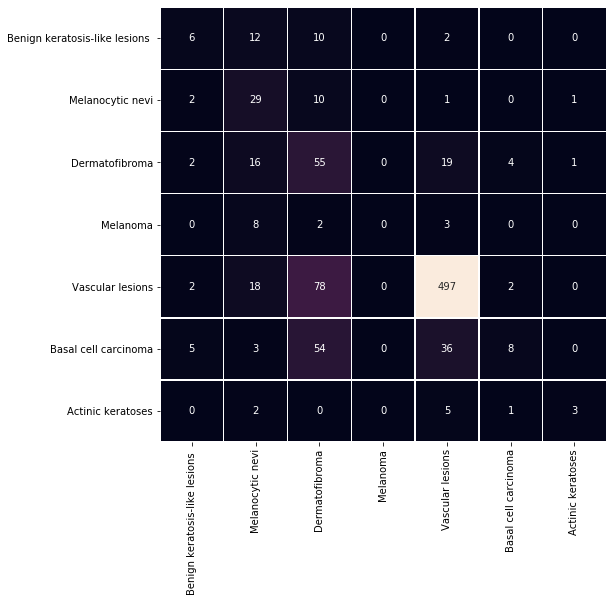

In [49]:
Y_pred = classifier.predict(x_validate)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_validate,axis = 1) 
cm = confusion_matrix(Y_true, Y_pred_classes)
label = pd.unique(skin_data['cell_type'])
f,ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(cm, xticklabels=label, yticklabels=label, linewidths=.5 , cbar=False , fmt="d" , annot=True)
plt.savefig("corr_relu_adagrad.png")
plt.show()

In [ ]:
# relu+Adam
classifier = Sequential()
input_shape = (75, 100, 3)

classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.25))

classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'relu', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))

classifier.add(Conv2D(128, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
classifier.add(Conv2D(128, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))


classifier.add(Flatten())
classifier.add(Dense(128, activation= 'relu'))
classifier.add(Dropout(0.5))


classifier.add(Dense(7, activation= 'softmax'))
classifier.summary()


classifier.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [51]:
epochs = 50
batch_size = 100
history = classifier.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/50
80/80 [==============================] - 31s 384ms/step - loss: 1.1732 - accuracy: 0.6569 - val_loss: 1.0737 - val_accuracy: 0.6633
Epoch 2/50
80/80 [==============================] - 28s 356ms/step - loss: 0.9614 - accuracy: 0.6679 - val_loss: 0.9114 - val_accuracy: 0.6656
Epoch 3/50
80/80 [==============================] - 29s 357ms/step - loss: 0.9016 - accuracy: 0.6702 - val_loss: 0.9125 - val_accuracy: 0.6678
Epoch 4/50
80/80 [==============================] - 29s 357ms/step - loss: 0.8732 - accuracy: 0.6795 - val_loss: 0.8801 - val_accuracy: 0.7001
Epoch 5/50
80/80 [==============================] - 29s 358ms/step - loss: 0.8456 - accuracy: 0.6898 - val_loss: 0.8870 - val_accuracy: 0.7023
Epoch 6/50
80/80 [==============================] - 29s 360ms/step - loss: 0.8168 - accuracy: 0.6974 - val_loss: 0.7994 - val_accuracy: 0.7146
Epoch 7/50
80/80 [==============================] - 29s 363ms/step - loss: 0.8193 - accuracy: 0.7002 - val_loss: 0.8587 - val_accuracy: 0.7068

In [52]:
loss, accuracy = classifier.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = classifier.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

897/897 [==============================] - 0s 508us/sample - loss: 0.6486 - accuracy: 0.7559
Validation: accuracy = 0.755853  ;  loss_v = 0.648577
Test: accuracy = 0.764056  ;  loss = 0.673568


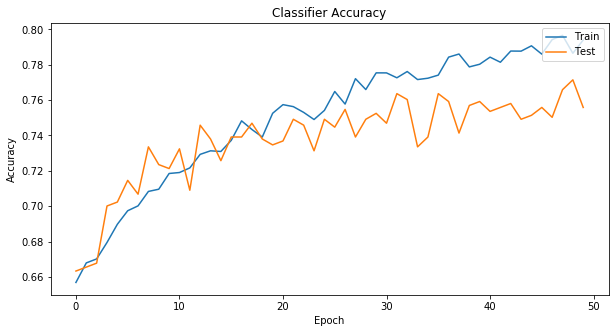

<Figure size 432x288 with 0 Axes>

In [53]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Classifier Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("relu+adam_acc.png")

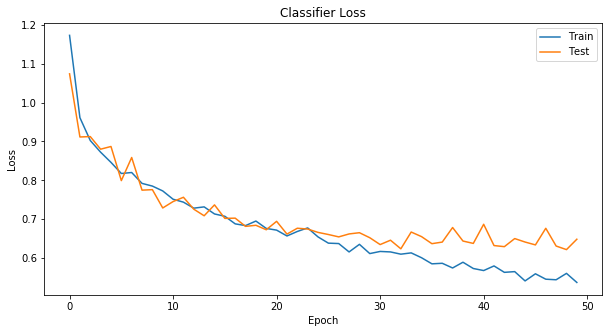

<Figure size 432x288 with 0 Axes>

In [54]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Classifier Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("relu+adam_loss.png")


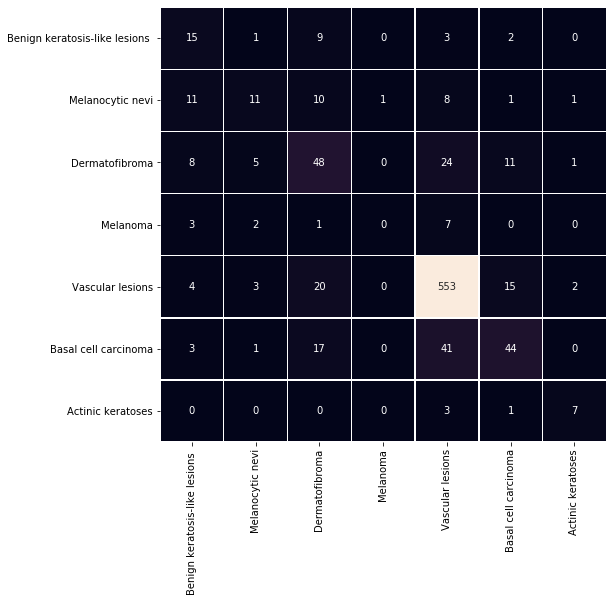

In [55]:
Y_pred = classifier.predict(x_validate)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_validate,axis = 1) 
cm = confusion_matrix(Y_true, Y_pred_classes)
label = pd.unique(skin_data['cell_type'])
f,ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(cm, xticklabels=label, yticklabels=label, linewidths=.5 , cbar=False , fmt="d" , annot=True)
plt.savefig("corr_relu_adam.png")
plt.show()

In [56]:
# relu+RMsprop
classifier = Sequential()
input_shape = (75, 100, 3)

classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.25))

classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'relu', padding= 'Same', input_shape = input_shape))
classifier.add(Conv2D(64, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))

classifier.add(Conv2D(128, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
classifier.add(Conv2D(128, kernel_size= (3,3), activation= 'relu', padding= 'Same'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))


classifier.add(Flatten())
classifier.add(Dense(128, activation= 'relu'))
classifier.add(Dropout(0.5))


classifier.add(Dense(7, activation= 'softmax'))
classifier.summary()


classifier.compile(optimizer='RMsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 18, 25, 64)       

In [57]:
epochs = 50
batch_size = 100
history = classifier.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/50
80/80 [==============================] - 18s 225ms/step - loss: 1.2678 - accuracy: 0.6457 - val_loss: 1.0186 - val_accuracy: 0.6656
Epoch 2/50
80/80 [==============================] - 18s 224ms/step - loss: 0.9777 - accuracy: 0.6648 - val_loss: 0.8884 - val_accuracy: 0.6711
Epoch 3/50
80/80 [==============================] - 16s 197ms/step - loss: 0.9272 - accuracy: 0.6677 - val_loss: 0.9698 - val_accuracy: 0.6923
Epoch 4/50
80/80 [==============================] - 16s 203ms/step - loss: 0.8977 - accuracy: 0.6787 - val_loss: 0.8879 - val_accuracy: 0.6823
Epoch 5/50
80/80 [==============================] - 17s 214ms/step - loss: 0.8517 - accuracy: 0.6900 - val_loss: 0.8695 - val_accuracy: 0.6789
Epoch 6/50
80/80 [==============================] - 17s 208ms/step - loss: 0.8363 - accuracy: 0.6986 - val_loss: 0.8543 - val_accuracy: 0.6878
Epoch 7/50
80/80 [==============================] - 16s 199ms/step - loss: 0.8069 - accuracy: 0.7068 - val_loss: 0.7695 - val_accuracy: 0.7191

In [58]:
loss, accuracy = classifier.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = classifier.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

897/897 [==============================] - 0s 504us/sample - loss: 0.6948 - accuracy: 0.7447
Validation: accuracy = 0.744705  ;  loss_v = 0.694773
Test: accuracy = 0.748996  ;  loss = 0.724799


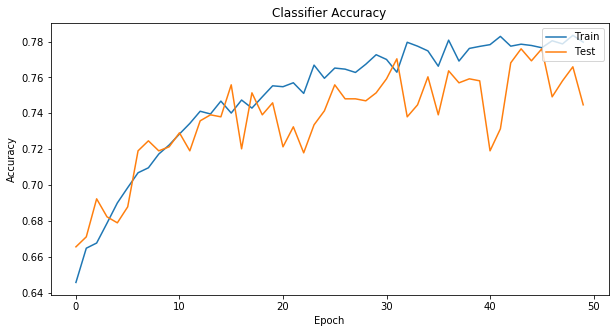

<Figure size 432x288 with 0 Axes>

In [59]:
fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Classifier Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("relu+RMsporp_acc.png")

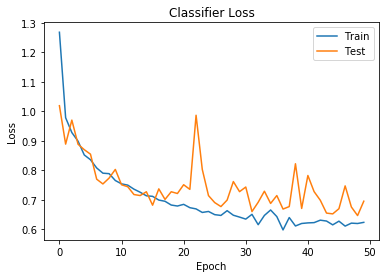

<Figure size 432x288 with 0 Axes>

In [64]:
# fig, ax1 = plt.subplots(figsize= (10, 5) )
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Classifier Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.savefig("relu+RMsprop_loss.png")


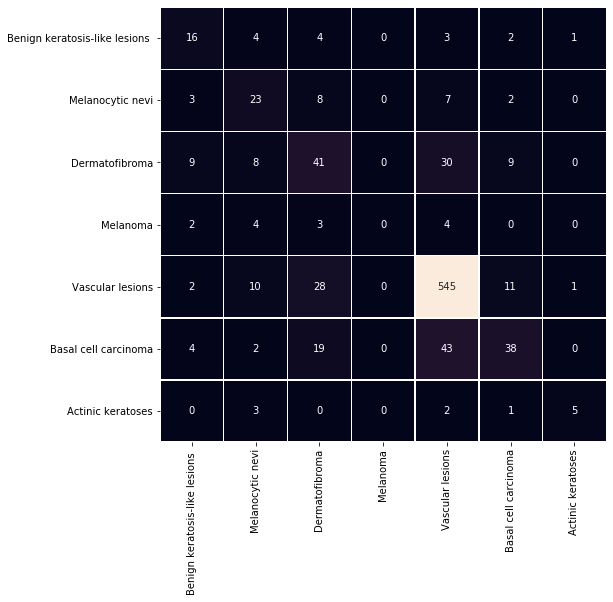

In [65]:
Y_pred = classifier.predict(x_validate)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_validate,axis = 1) 
cm = confusion_matrix(Y_true, Y_pred_classes)
label = pd.unique(skin_data['cell_type'])
f,ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(cm, xticklabels=label, yticklabels=label, linewidths=.5 , cbar=False , fmt="d" , annot=True)
plt.savefig("corr_relu_rmsprop.png")
plt.show()